# Recommender Systems

Recommender systems are critical in providing personalized proposals for users across various fields. In this assignment, we aim to evaluate the performance of three algorithms covered in the course, namely Naive methods, UV matrix decomposition, and matrix factorization, and to provide insights into their effectiveness using the MovieLens 1M data set. Additionally, we used 5-fold cross-validation to increase the reliability of our recommender systems' results for data (movie or user) that did not occur in the training process. After implementing each of the algorithms, we used the Root Mean Squared Error (RMSE) and the Mean Absolute Error (MAE) over both the training and the test set for the examination of their accuracy.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import chardet
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.lines as mlines
import math
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from tqdm import tqdm

np.random.seed(42)

## Loading data

It appears that there is inconsistency in the text encoding used in various data files. As a result, we must verify the encoding to ensure accurate data reading from these files.

In [2]:
def get_file_encoding(file_path):
    """
    This function checks the text enconding used in a particular file
    
    :param file_path: The file path you wish to examine for its encoding
    :return: String containing enconding type
    """
    
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
        return result['encoding']

In [3]:
# Loading ratings data
ratings_path ="./ratings.dat"
ratings = pd.read_csv(ratings_path, delimiter="::", header=None, engine='python', encoding=get_file_encoding(ratings_path))
ratings = ratings.rename(columns={0: "UserID", 1: "MovieID", 2: "Rating", 3:"Timestamp"}) # Set ratings column names

ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
# Loading movies data
movies_path = "./movies.dat"
movies = pd.read_csv(movies_path, delimiter="::", header=None, engine='python', encoding= get_file_encoding(movies_path))
movies = movies.rename(columns={0: "MovieID", 1: "Title", 2: "Genres"})

movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# Loading users data
users_path = "./users.dat"
users = pd.read_csv(users_path, delimiter="::", header=None, engine='python', encoding= get_file_encoding(users_path))
users = users.rename(columns={0: "UserID", 1: "Gender", 2: "Age", 3: "Occupation", 4: "Zip-code"})

users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


#### Missing values check:

In [6]:
print(ratings.isna().sum().sum())
print(movies.isna().sum().sum())
print(users.isna().sum().sum())

0
0
0


# Naive Approaches

To begin with the first recommender systems algorithm, we implement four functions for each naive recommender approach, namely the Global Average, the Movie Average, the User Average, and the Linear combination (including the $\gamma$ parameter). The first one, the Global Average approach, involves recommending the global average rating to all users. When movie or user average ratings were unavailable for the Movie Average or User Average approach, this approach was utilized as a fallback value. Proceeding to these approaches, recommendations were based on the average rating received by a movie or given by a user, respectively. Finally, the last approach we implemented was the Linear combination of the three averages. In this approach, predictions are a combination of user and movie average ratings, with the $\gamma$ term included. In that case, we used the Movie and User Average Ratings in the Linear Combination function. Thus, the fall-back value used for these approaches was used indirectly for the fourth one when user or movie average ratings were unavailable. Hence, in the last approach, the global average rating was implicitly used again as the fall-back value.

### Import Libraries

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### 1. Global Average Rating:

$$ {R}_{global} (User, Movie) = mean(\text{all ratings})$$

In [12]:
def global_average(train, test, is_train=False):
    if is_train:
        return [train['Rating'].mean()] * len(train)
    else:
        return [train['Rating'].mean()] * len(test)

#### 2. Movie Average: 

$$ {R}_{movie} (User, Movie) = mean(\text{all ratings for movie})$$

In [13]:
def movie_average(train, test, is_train=False):
    if is_train:
        movie_avg_train = train.groupby('MovieID')['Rating'].mean()
        return movie_avg_train[train['MovieID']].to_numpy()    # A NumPy ndarray representing the values in this Series

    else:
        movie_avg_predictions = test['MovieID'].map(train.groupby('MovieID')['Rating'].mean())  # movie average predictions for a test set based on 
        movie_avg_predictions.fillna(train['Rating'].mean(), inplace=True)                       # the movie average ratings in the training set             
        return movie_avg_predictions

#### 3. User Average:

$$ {R}_{user} (User, Movie) = mean(\text{all ratings for User})$$

In [14]:
def user_average(train, test, is_train=False):
    if is_train:
        user_avg_train = train.groupby('UserID')['Rating'].mean()
        return user_avg_train[train['UserID']].to_numpy()    # A NumPy ndarray representing the values in this Series

    else:
        user_avg_predictions = test['UserID'].map(train.groupby('UserID')['Rating'].mean()) # user average predictions for a test set based on 
        user_avg_predictions.fillna(train['Rating'].mean(), inplace=True)                       # the user average ratings in the training set
        return user_avg_predictions


#### 4. Linear Combination of the three averages:

$$ {R}_{user-movie} (User, Movie) = \alpha * {R}_{user} (User, Movie) + \beta * {R}_{movie} (User, Movie) + \gamma$$

In [15]:
def linear_combination(train, test, is_train=False):
    user_avg = train.groupby('UserID')['Rating'].mean()
    movie_avg = train.groupby('MovieID')['Rating'].mean()

    A = np.vstack([user_avg[train['UserID']], movie_avg[train['MovieID']], np.ones(len(train))]).T
    b = train['Rating']

    alpha, beta, gamma = np.linalg.lstsq(A, b, rcond=None)[0]     # https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html

    if is_train: 
        prediction = alpha * user_average(train, test, is_train=True) + beta * movie_average(train, test, is_train=True) + gamma
    else:
        prediction = alpha * user_average(train, test) + beta * movie_average(train, test) + gamma

    prediction = np.clip(prediction, 1, 5)

    return prediction
    


## 5-fold Cross-Validation \& Accuracy estimations

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)   # 42: random seed set at the beginning

# training set
rmse_global_train = []
mae_global_train = []

rmse_user_train = []
mae_user_train = []

rmse_movie_train = []
mae_movie_train = []

rmse_combination_train = []
mae_combination_train = []

# test set
rmse_global_test = []
mae_global_test = []

rmse_user_test = []
mae_user_test = []

rmse_movie_test = []
mae_movie_test = []

rmse_combination_test = []
mae_combination_test = []

for train_index, test_index in kf.split(ratings):
    train_data, test_data = ratings.iloc[train_index], ratings.iloc[test_index]

    # Compute RMSE and MAE over training set
    rmse_global_train.append(np.sqrt(mean_squared_error(train_data['Rating'], global_average(train_data, test_data, is_train=True))))
    mae_global_train.append(mean_absolute_error(train_data['Rating'], global_average(train_data, test_data, is_train=True)))

    rmse_user_train.append(np.sqrt(mean_squared_error(train_data['Rating'], user_average(train_data, test_data, is_train=True))))
    mae_user_train.append(mean_absolute_error(train_data['Rating'], user_average(train_data, test_data, is_train=True)))

    rmse_movie_train.append(np.sqrt(mean_squared_error(train_data['Rating'], movie_average(train_data, test_data, is_train=True))))
    mae_movie_train.append(mean_absolute_error(train_data['Rating'], movie_average(train_data, test_data, is_train=True)))

    rmse_combination_train.append(np.sqrt(mean_squared_error(train_data['Rating'], linear_combination(train_data, test_data, is_train=True))))
    mae_combination_train.append(mean_absolute_error(train_data['Rating'], linear_combination(train_data, test_data, is_train=True)))

    # Compute RMSE and MAE test set
    rmse_global_test.append(np.sqrt(mean_squared_error(test_data['Rating'], global_average(train_data, test_data))))
    mae_global_test.append(mean_absolute_error(test_data['Rating'], global_average(train_data, test_data)))

    rmse_user_test.append(np.sqrt(mean_squared_error(test_data['Rating'], user_average(train_data, test_data))))
    mae_user_test.append(mean_absolute_error(test_data['Rating'], user_average(train_data, test_data)))

    rmse_movie_test.append(np.sqrt(mean_squared_error(test_data['Rating'], movie_average(train_data, test_data))))
    mae_movie_test.append(mean_absolute_error(test_data['Rating'], movie_average(train_data, test_data)))

    rmse_combination_test.append(np.sqrt(mean_squared_error(test_data['Rating'], linear_combination(train_data, test_data))))
    mae_combination_test.append(mean_absolute_error(test_data['Rating'], linear_combination(train_data, test_data)))


In [17]:
d_train = {"Metric": ["RMSE", "MAE"],
          "Global Average": [np.mean(rmse_global_train).round(3), np.mean(mae_global_train).round(3)],
          "User Average": [np.mean(rmse_user_train).round(3), np.mean(mae_user_train).round(3)],
          "Movie Average": [np.mean(rmse_movie_train).round(3), np.mean(mae_movie_train).round(3)],
          "Linear Combination": [np.mean(rmse_combination_train).round(3),np.mean(mae_combination_train).round(3)]}
df_train = pd.DataFrame(data=d_train)

d_test = {"Metric": ["RMSE", "MAE"],
          "Global Average": [np.mean(rmse_global_test).round(3), np.mean(mae_global_test).round(3)],
          "User Average": [np.mean(rmse_user_test).round(3), np.mean(mae_user_test).round(3)],
          "Movie Average": [np.mean(rmse_movie_test).round(3), np.mean(mae_movie_test).round(3)],
          "Linear Combination": [np.mean(rmse_combination_test).round(3),np.mean(mae_combination_test).round(3)]}
df_test = pd.DataFrame(data=d_test)

#### RMSE and MAE table over training set:

In [18]:
df_train     

,Metric,Global Average,User Average,Movie Average,Linear Combination
0,RMSE,1.117,1.028,0.974,0.915
1,MAE,0.934,0.823,0.778,0.725


#### RMSE and MAE table over test set:

In [19]:
df_test

,Metric,Global Average,User Average,Movie Average,Linear Combination
0,RMSE,1.117,1.035,0.979,0.924
1,MAE,0.934,0.829,0.782,0.732


#### Discussion on RMSE - MAE tables

We compute the RMSE and MAE over both the training and test sets to assess how well the model performs during training (learning) and when applied to unknown data (testing). Consequently, in both sets, the Linear Combination approach is the most accurate naïve method, implying that considering both user and movie average ratings, with the parameter $\gamma$ in the linear regression model, leads to better recommendations. On the contrary, the Global Average approach is less accurate but still provides valid and straightforward recommendations, making it an acceptable starting point. As for the User Average and Movie Average, their RMSE and MAE values fall in between the Global Average and Linear Combination, indicating that personalized recommendations based on user or movie averages can be reasonably accurate.
Overall, the differences in RMSE and MAE values among the four approaches are relatively small, indicating that these naive approaches provide competitive in accuracy results for this dataset.

# UV Matrix Decomposition

### k-fold Cross Validation

In [ ]:
def rsme(y_true, y_pred):
    return math.sqrt(np.square(np.subtract(y_true, y_pred)).mean())

In [ ]:
def mae(y_true, y_pred):
    return np.absolute(np.subtract(y_true, y_pred)).mean()

In [ ]:
def cross_validation(model, X, y, k = 5):
    # Shuffle data
    X, y = shuffle(X, y, random_state=42)
    
    # Split data
    n = len(X)
    X_folds = [X.iloc[(i - 1) * (n // k):i * (n // k),:] for i in range(1, k + 1)]
    y_folds = [y.iloc[(i - 1) * (n // k):i * (n // k)] for i in range(1, k + 1)]
    
    # Initialize array to store RSME calculations
    rmse_ = np.empty((0, 2), float)
    mae_ = np.empty((0, 2), float)
    
    
    for i, (X_test, y_test) in enumerate(zip(X_folds, y_folds)):
        X_train = pd.concat([X for j, X in enumerate(X_folds) if i != j])
        y_train = pd.concat([y for j, y in enumerate(y_folds) if i != j])
        
        # Train model
        model.fit(X_train, y_train)
        
        # Evaluate on training and test set
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate errors
        rmse_train = rsme(y_train, y_train_pred) 
        rmse_test = rsme(y_test, y_test_pred)
        mae_train = mae(y_train, y_train_pred)
        mae_test = mae(y_test, y_test_pred)
        
        rmse_ = np.append(rmse_, np.array([[rmse_train, rmse_test]]), axis = 0)
        mae_ = np.append(mae_, np.array([[mae_train, mae_test]]), axis = 0)
    
    rmse_train_aver = rmse_[:, 0].mean()
    rmse_test_aver = rmse_[:, 1].mean()
    mae_train_aver = mae_[:, 0].mean()
    mae_test_aver = mae_[:, 1].mean()
    
    return (rmse_train_aver, rmse_test_aver), (mae_train_aver, mae_test_aver)

## Naive Approaches

In [ ]:
class NaiveApproach:
    def __init__(self, fit = lambda *args: None, predict = lambda *args: None):
        self.predict = predict
        self.fit = fit

In [ ]:
X = ratings[['UserID', 'MovieID']]
y = ratings['Rating']

### Global average rating

$$
R_{global}(User, Item)=mean(\text{all ratings})
$$

In [ ]:
r_global = ratings['Rating'].mean()
r_global

3.581564453029317

In [ ]:
# Cross validation
global_average_rating_model = NaiveApproach(predict=lambda *args: r_global)
(_, rmse_test) , (_, mae_test) = cross_validation(global_average_rating_model, X, y)

print(f'RSME: {round(rmse_test, 3)}\nMAE: {round(mae_test, 3)}')

RSME: 1.117
MAE: 0.934


### Average rating per Item

$$
R_{item}(User, Item)=mean(\text{all ratings for Item})
$$

In [ ]:
def r_item(item):
    ratings_item = ratings[(ratings['MovieID'] == item)]
    return ratings_item['Rating'].mean() if len(ratings_item) > 0 else r_global

In [ ]:
# Compute average rates of all items
R_i = {}

for movieID in ratings['MovieID'].unique():
    R_i[movieID] = r_item(movieID)

In [ ]:
# Cross validation
average_rating_item_model = NaiveApproach(predict=lambda X: X['MovieID'].apply(lambda x: R_i[x]))
(_, rmse_test) , (_, mae_test) = cross_validation(average_rating_item_model, X, y)

print(f'RSME: {round(rmse_test, 3)}\nMAE: {round(mae_test, 3)}')

RSME: 0.975
MAE: 0.779


### Average rating per User

$$
R_{User}(User, Item)=mean(\text{all ratings for User})
$$

In [ ]:
def r_user(user):
    ratings_user = ratings[(ratings['UserID'] == user)]
    return ratings_user['Rating'].mean() if len(ratings_user) > 0 else r_global

In [ ]:
# Compute average rates of all users
R_u = {}

for userID in ratings['UserID'].unique():
    R_u[userID] = r_user(userID)

In [ ]:
# Cross validation
average_rating_user_model = NaiveApproach(predict=lambda X: X['UserID'].apply(lambda x: R_u[x]))
(_, rmse_test) , (_, mae_test) = cross_validation(average_rating_user_model, X, y)

print(f'RSME: {round(rmse_test, 3)}\nMAE: {round(mae_test, 3)}')

RSME: 1.028
MAE: 0.823


### Optimal Linear Combination of 2 averages

$$
R_{user-item}(User, Item) = \alpha * R_{user}(User, Item) + \beta * R_{item}(User, Item) + \gamma
$$

In [ ]:
class LinearCombination:
    def fit(self, X, y):
        y = y.to_numpy()
        
        X_u = X['UserID'].apply(lambda x: R_u[x]).to_numpy()
        X_i = X['MovieID'].apply(lambda x: R_i[x]).to_numpy()
        X = np.vstack([X_u, X_i])
        
        A = np.vstack([X, np.ones(X.shape[1])]).T
        self.alpha, self.beta, self.gamma = np.linalg.lstsq(A, y, rcond=None)[0]
    
    def formula(self, r_u, r_i):
        return 
    
    def predict(self, X):
        r_u = X['UserID'].apply(lambda x: R_u[x])
        r_i = X['MovieID'].apply(lambda x: R_i[x])
        
        return self.alpha * r_u + self.beta * r_i + self.gamma

In [ ]:
# Cross validation
linear_combination_model = LinearCombination()
(_, rmse_test) , (_, mae_test) = cross_validation(linear_combination_model, X, y)

print(f'RSME: {round(rmse_test, 3)}\nMAE: {round(mae_test, 3)}')

RSME: 0.916
MAE: 0.726


## UV Decomposition

In [ ]:
class roundrobin:
    def __init__(self, U, V):
        self.U = U
        self.V = V
        
        self.maxrows1, self.maxcols1 = U.shape[0], U.shape[1]
        self.maxrows2, self.maxcols2 = V.shape[0], V.shape[1]
        
        
    def __iter__(self):
        self.iterU = True
        self.row1 = self.col1 = 0
        self.row2 = self.col2 = 0
        return self

    def __next__(self):
        if self.iterU:
            if self.row1 > self.maxrows1 - 1:
                self.row1 = 0
                self.col1 += 1
                if self.col1 > self.maxcols1 - 1:
                    raise StopIteration

            next_ = (self.iterU, self.row1, self.col1)
            self.iterU = False
            self.row1 += 1
            return next_
        else:    
            if self.row2 > self.maxrows2 - 1:
                self.row2 = 0
                self.col2 += 1
                if self.col2 > self.maxcols2 - 1:
                    raise StopIteration

            next_ = (self.iterU, self.row2, self.col2)
            self.iterU = True
            self.row2 += 1
            return next_

### Preprocessing

In [ ]:
# n Users
unique_users = ratings['UserID'].unique()
n = len(unique_users)

# m Items
unique_items = ratings['MovieID'].unique()
m = len(unique_items)

# Initialize utility matrix
M = np.full((n,m), np.nan)

In [ ]:
# Map ids to index & vice-versa
user_to_index = {user_id: idx for idx, user_id in enumerate(unique_users)}
index_to_user = {idx: user_id for idx, user_id in enumerate(unique_users)}

item_to_index = {item_id: idx for idx, item_id in enumerate(unique_items)}
index_to_item = {idx: item_id for idx, item_id in enumerate(unique_items)}

In [ ]:
# Populate matrix M
for _, row in ratings.iterrows():
    user_id = row['UserID']
    item_id = row['MovieID']
    
    norm = (R_u[user_id] + R_i[item_id]) / 2
    
    M[user_to_index[user_id], item_to_index[item_id]] = row['Rating'] - norm

In [ ]:
# Define loss function
def rmse_2d(M, M_pred):
    mask = ~np.isnan(M)
    return math.sqrt(np.mean(np.square(M - M_pred), where=~np.isnan(M)))

### Initialization

In [ ]:
# Length of short sizes of U & V
d = 10

# Mean of non-blank values in M
a = np.mean(M, where=~np.isnan(M))

initial_value = math.sqrt(a/d)

U = np.full((n, d), initial_value)
V = np.full((d, m), initial_value)

### Performing the Optimization

#### Optimizing elements of U
$$
x = \frac{\sum_{j} v_{sj}(m_{rj} - \sum_{k \neq s} u_{rk}v_{kj})}{\sum_{j} v^{2}_{sj}}
$$


In [ ]:
def optimize_x(M, U, V, r, s):
    urk = np.delete(U[r, :], s, axis=0)
    vkj = np.delete(V, s, axis=0)

    vsj = V[s, :]

    numerator = vsj * (M[r, :] - np.dot(urk.reshape(-1,1).T, vkj))
    numerator = np.sum(numerator, where=~np.isnan(numerator))

    denominator = np.square(vsj)
    denominator = np.sum(denominator)

    return numerator / denominator

#### Optimizing elements of V
$$
y = \frac{\sum_{i} u_{ir}(m_{is} - \sum_{k \neq r} u_{ik}v_{ks})}{\sum_{i} u^{2}_{ir}}
$$

In [ ]:
def optimize_y(M, U, V, r, s):   
    uik = np.delete(U, r, axis=1)
    vks = np.delete(V[:,s], r, axis=0)
    
    uir = U[:,r]
   
    numerator = uir * (M[:,s] - np.dot(uik, vks))
    numerator = np.sum(numerator, where=~np.isnan(numerator))

    denominator = np.square(uir)
    denominator = np.sum(denominator, where=~np.isnan(denominator))

    return numerator / denominator

#### Optimizing decompositions U and V

In [ ]:
UV = np.dot(U, V)
print(f'Initial RMSE: {rmse_2d(M, UV)}')

Initial RMSE: 0.9515933193173758


In [ ]:
same_err = 0
last_err = float('inf')
for _ in tqdm(range(15)):
    # Stop if error doesn't improve for 3 epochs
    if same_err >= 3:
      break

    # Training
    for isU, r, s in roundrobin(U, V):
        if isU:
            U[r,s] = optimize_x(M, U, V, r, s)
        else:
            V[r,s] = optimize_y(M, U, V, r, s)
    
    # Monitoring
    UV = np.dot(U, V)
    err = round(rmse_2d(M, UV),3)
    if err == last_err:
      same_err += 1
    last_err = err

    print(f'RMSE: {err}')

  7%|██▉                                         | 1/15 [00:14<03:16, 14.05s/it]

RMSE: 0.914


 13%|█████▊                                      | 2/15 [00:26<02:53, 13.32s/it]

RMSE: 0.903


 20%|████████▊                                   | 3/15 [00:40<02:39, 13.33s/it]

RMSE: 0.9


 27%|███████████▋                                | 4/15 [00:52<02:22, 12.98s/it]

RMSE: 0.898


 33%|██████████████▋                             | 5/15 [01:04<02:05, 12.56s/it]

RMSE: 0.897


 40%|█████████████████▌                          | 6/15 [01:18<01:56, 12.94s/it]

RMSE: 0.895


 47%|████████████████████▌                       | 7/15 [01:33<01:49, 13.75s/it]

RMSE: 0.894


 53%|███████████████████████▍                    | 8/15 [01:47<01:35, 13.68s/it]

RMSE: 0.893


 60%|██████████████████████████▍                 | 9/15 [02:00<01:21, 13.54s/it]

RMSE: 0.892


 67%|████████████████████████████▋              | 10/15 [02:12<01:05, 13.20s/it]

RMSE: 0.892


 73%|███████████████████████████████▌           | 11/15 [02:25<00:52, 13.07s/it]

RMSE: 0.891


 80%|██████████████████████████████████▍        | 12/15 [02:39<00:39, 13.21s/it]

RMSE: 0.891


 87%|█████████████████████████████████████▎     | 13/15 [02:51<00:26, 13.19s/it]

RMSE: 0.891


In [ ]:
UV = np.dot(U, V)
print(f'Optimized RMSE: {rmse_2d(M, UV)}')

Optimized RMSE: 0.8910636397215524


In [ ]:
# Cross validation
def decomp_predict(X_test):
    y_pred = []
    for _, x in X_test.iterrows():
        user_id = x['UserID']
        item_id = x['MovieID']
        norm = (R_u[user_id] + R_i[item_id]) / 2
        y_pred.append(UV[user_to_index[user_id], item_to_index[item_id]] + norm)
        
    return y_pred
    
uv_decomposition_model = NaiveApproach(predict=decomp_predict)
(_, rmse_test) , (_, mae_test) = cross_validation(uv_decomposition_model, X, y)

print(f'RSME: {round(rmse_test, 3)}\nMAE: {round(mae_test, 3)}')

RSME: 0.891
MAE: 0.708


# Matrix Factorization with Gradient Descent and Regularization

For this part of the report, matrix factorization algorithm is going to be implemented in a similar way with the one described in the gravity-Tikk.pdf paper. To be more specific, this algorithm takes as an input a Ratings Matrix, where each row i represents users, each column j represents movies and the (i,j) element of the matrix is the rating of user i to the movie j. However, this matrix has many elements that are zeros, since not all users have rated all the movies.  So, the algorithm aims to predict the zero elements of the matrix by filling the whole Ratings matrix. To achieve that, it decompose the Ratings matrix into the product of two matrices U (for users) and M (for movies). The U matrix has as many rows as the users and K columns, whereas the M matrix has as many columns as the movies are and K rows. The value of K is going to be chosen, based on the smaller achieved test root mean squares error(RMSE) and mean absolute error(MAE), after some experiments are conducted. The goal of the algorithm is to minimize the difference between the predicted ratings matrix and the real one ratings matrix, taking into account, while calculating that difference, only the (i,j) elements of the matrices that were not initialy zero in the real ratings matrix. The problem is solved using a gradient method to adjust elements of U and M in each iteration, so that to minimize the error between the real rating and the predicted rating. Additionally, regularization is applied to prevent overfitting. The first thing that the algorithm does is to initialize the  U and M matrices randomly and then choose learning rate (η), regularization factor (λ), K and max number of iterations. Then, it iteratively updates U and M untill the RMSE on the probe subset(list of [i,j,rating] elements, where the rating is not 0 on the real ratings matrix) stop decreasing for two consecutive iterations or untill the max number of iterations chosen. In addition to the gravity-Tikk.pdf paper, the gradients here are penalized to not exceed the value of 1 and the predicted ratings matrix is squeezed to [1,5], meaning that values less than 1 are changed to be 1 and values greater than 5, are changed to be 5. Also, if the RMSE does not reduce for two consecutive iterations but it is not lower than 1, the algorithm continues untill it reaches the maximum number of iterations.

Since this algorithm takes hours to run, the experiments are run using the parameters that are reported on the MyMedialite website: num_factors=10, num_iter=75, regilarization=0/05, learnr_rate=0.05.



Before implementing the algorthim though, some preprocessing of the data should be done. 

## Pre-processing Data

The users and movies dataframes are encoded in order to have continues userID and movieID values without any gaps. Their indexes are also reset to be continuous. That is because we want each row of the Ratings matrix to be able to be mapped with the respective userID and each column of the Ratings matrix to be able to be mapped with the respective row of the movieID.

In [ ]:
le = LabelEncoder()

unique_users_ids = ratings.loc[:,'UserID'].unique().copy()
# Assuming your movies features matrix is named 'movies_features_df'
filtered_users = users[users.loc[:,'UserID'].isin(unique_users_ids)].copy()

unique_movies_ids = ratings.loc[:,'MovieID'].unique().copy()
# Assuming your movies features matrix is named 'movies_features_df'
filtered_movies = movies[movies.loc[:,'MovieID'].isin(unique_movies_ids)].copy()


filtered_movies.loc[:, 'MovieID'] = le.fit_transform(filtered_movies['MovieID']).copy()
filtered_users.loc[:, 'UserID'] = le.fit_transform(filtered_users['UserID']).copy()

In [ ]:
filtered_movies.reset_index(drop=True, inplace=True)
filtered_users.reset_index(drop=True, inplace=True)

Finally the Ratings matrix is created as a dataframe and named as 'user_movie_retings'. Each row represents a UserID and each column a MovieID. In this matrix all the users ratings are presented. The zeros in the matrix represent movies that the specific user have not rated.

In [ ]:
user_movie_ratings = ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)

# Encode columns (MovieIDs)
user_movie_ratings.columns = le.fit_transform(user_movie_ratings.columns)

# Encode row names (UserIDs)
user_movie_ratings.index = le.fit_transform(user_movie_ratings.index)

## Implementing the algorithm


Here a class named MatrixFactorization is created to implement the aformentioned algorithm. It is initialized with the values of K, max iterations, η and λ. Then, the algorthm is performed in the .fit instance, using operations on matrices in order to avoid nested loops which are slow. U and M are initialized using the random library. The class has also instances to return the predicted ratings matrix, the mae and rmse of the train set and the rmse and mae on the test set. 

In [ ]:
class MatrixFactorization:
    def __init__(self, K=10, max_iter=75, eta=0.005, lamda=0.05):
        self.K = K  # Features of matrices
        self.max_iter = max_iter  # Maximum number of iterations
        self.eta = eta  # Learning rate
        self.lamda = lamda  # Regularization parameter

    def fit(self, train_set):
        self.zero_rows=np.where(~train_set.values.any(axis=1))[0] #
        self.zero_columns=np.where(~train_set.values.any(axis=0))[0]

        prev_rmse = float('inf')
        consecutive_increase_count = 0

        probe_subset = [(i, j, train_set.iloc[i, j]) for i in range(len(train_set)) for j in range(len(train_set.columns)) if train_set.iloc[i, j] > 0]

        N, Z = train_set.shape  # Dimensions of the user-item matrix
        self.train_set_values=train_set.values

        self.U = np.random.rand(N, self.K)  # Initialize user matrix randomly
        self.M = np.random.rand(Z, self.K)  # Initialize movie matrix randomly

        raw_predictions = np.dot(self.U, self.M.T)
        self.predictions =  np.clip(raw_predictions, 1, 5)

        plot_rmse_train=[]
        plot_rmse_test=[]
        for step in range(self.max_iter):
            # Calculate errors for non-zero entries in train_set
            train_values = np.where(np.isnan(train_set.values), 0, train_set.values) #put zero where there is nan
            U_values = np.where(np.isnan(self.U), 0, self.U)
            M_T_values = np.where(np.isnan(self.M.T), 0, self.M.T)

            errors = (train_values > 0) * (train_values - np.dot(U_values, M_T_values)) #erors in all positions of array without zeros in train


            # Calculate gradients for U and M using matrix operations
            gradient_U = 2 * (np.dot(errors, self.M) - self.lamda * self.U)
            gradient_M = 2 * (np.dot(errors.T, self.U) - self.lamda * self.M)


            max_gradient = 1.0  # Set an appropriate maximum gradient value
            gradient_U = np.clip(gradient_U, -max_gradient, max_gradient)
            gradient_M = np.clip(gradient_M, -max_gradient, max_gradient)

            self.U += self.eta * gradient_U
            self.M += self.eta * gradient_M

            raw_predictions = np.dot(self.U, self.M.T)
            self.predictions =  np.clip(raw_predictions, 1, 5)

            # Calculate RMSE on the probe subset
            train_probe_rmse = self.get_rmse(probe_subset)
            train_probe_mae = self.get_mae(probe_subset)


            print("Iteration:", step + 1, " train RMSE:", train_probe_rmse, "train MAE:", train_probe_mae)

            plot_rmse_train.append(train_probe_rmse)

            # Check for convergence by comparing RMSE with the previous iteration
            if train_probe_rmse >= prev_rmse:
                consecutive_increase_count += 1
                if consecutive_increase_count >= 2 and train_probe_rmse<=1:
                    print("Converged. RMSE did not decrease for 2 consecutive iterations.")
                    print('Train RMSE:',train_probe_rmse)
                    print('Train MAE:',train_probe_mae)
                    break
            else:
                consecutive_increase_count = 0

            prev_rmse = train_probe_rmse


        raw_predictions = np.dot(self.U, self.M.T)
        self.predictions =  np.clip(raw_predictions, 1, 5)


        return train_probe_rmse,train_probe_mae, plot_rmse_train

    def predict(self):
        return self.predictions


    def test_rmse_mae(self, test_data):
        test_data = test_data.values
        nR = self.predictions

        non_zero_mask = (test_data > 0) & np.logical_not(np.isin(np.arange(len(test_data)), self.zero_rows)[:, np.newaxis]) & np.logical_not(np.isin(np.arange(len(test_data[0])), self.zero_columns))
        actual_ratings = test_data[non_zero_mask]
        predicted_ratings = nR[non_zero_mask]

        rmse = np.sqrt(np.mean((predicted_ratings - actual_ratings) ** 2))
        mae = np.mean(np.abs(predicted_ratings - actual_ratings))

        return rmse, mae


    def get_rmse(self, probe_subset):
        rmse = 0
        count = 0
        for i, j, actual_rating in probe_subset:
            predicted_rating = self.predictions [i,j]
            rmse += (predicted_rating - actual_rating) ** 2
            count += 1
        rmse = np.sqrt(rmse / count)
        return rmse

    def get_mae(self, probe_subset):
        mae = 0
        count = 0
        for i, j, actual_rating in probe_subset:
            predicted_rating = self.predictions [i,j]
            mae += np.abs(predicted_rating - actual_rating)
            count += 1
        mae = mae / count
        return mae




## Cross validation


For the results to be more accurate 5-fold cross validation is performed using a function named cross_validation. This function takes as input the model, which is from the MatrixFactorization class, the dataphrame with the real ratings and the number of folds that the dataphrame is going to be split into. To split the data into 4 train sets and 1 test set, a list of tubles is created with (user,movie, rating) elements, for the elements of the matrix that are non zero. Then the train matrix, which has the same shape as the original matrix is filled with the 4/5 of those data and the test matrix, which also has the same shape as the original matrix is filled with the 1/5 of those data. This happens for 5 times in order to have different combinations of train and test sets. If a user or a movie is not presented in the train matrix (i.e all elements of a specific row (user) are filled with zeros or all elements of a specific column (movie) are filled with zeros), then that user and that movie are not taking into account when calculation the RMSE and MAE on the test data. In the cross validation function, the fit instance of the model is called for every one of the five times that the spliting is performed and for each time the test RMSE and MAE are calculated and printed. At the end, the avairage of those values is also printed.

In [ ]:
def cross_validation(model, data_df, num_folds=5):


    num_users, num_movies = data_df.shape

    # Create a list of (user, movie, rating) tuples from the DataFrame
    data = [(user, movie, data_df.iloc[user, movie]) for user in range(num_users) for movie in range(num_movies) if data_df.iloc[user, movie] != 0]


    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Initialize empty DataFrames for train and test sets
    train_sets = [pd.DataFrame(np.zeros((num_users, num_movies))) for _ in range(num_folds)]
    test_sets = [pd.DataFrame(np.zeros((num_users, num_movies))) for _ in range(num_folds)]

    # Iterate through the folds
    train_sum_rmse = 0
    train_sum_mae = 0

    test_sum_rmse = 0
    test_sum_mae = 0

    plot_train=[]
    for fold, (train_index, test_index) in enumerate(kf.split(data), 1):
        train_data = [data[i] for i in train_index]
        test_data = [data[i] for i in test_index]

        # Fill train and test DataFrames with ratings from the respective data tuples
        for user, movie, rating in train_data:
            train_sets[fold - 1].iloc[user, movie] = rating

        for user, movie, rating in test_data:
            test_sets[fold - 1].iloc[user, movie] = rating

        mf = model
        (train_rmse,train_mae, plot_train_rmse) = mf.fit(train_sets[fold - 1])

        plot_train.append(plot_train_rmse)

        (test_rmse,test_mae) =mf.test_rmse_mae(test_sets[fold - 1])

        print('Final train RMSE for fold:',fold,':', train_rmse)
        print('Final train MAE for fold:',fold,':', train_mae)

        print('Final test RMSE for fold:',fold,':', test_rmse)
        print('Final test MAE for fold:',fold,':', test_mae)

        train_sum_rmse = train_sum_rmse + train_rmse
        train_sum_mae = train_sum_mae + train_mae


        test_sum_rmse = test_sum_rmse + test_rmse
        test_sum_mae = test_sum_mae + test_mae

    overall_train_rmse=train_sum_rmse/num_folds
    overall_train_mae=train_sum_mae/num_folds

    overall_test_rmse=test_sum_rmse/num_folds
    overall_test_mae=test_sum_mae/num_folds

    print('Overall Train RMSE:',overall_train_rmse)
    print('Overall Train MAE:',overall_train_mae)

    print('Overall Test RMSE:',overall_test_rmse)
    print('Overall Test MAE:',overall_test_mae)

    return plot_train,  overall_test_rmse


## Run experiments

Time to run the experiments. The cross validation function is called 3 times, each time with a different value of K in order to compare their performance. The values that are tried are K=10,15,20

In [ ]:
data_df=user_movie_ratings

In [ ]:
model1=MatrixFactorization()
(plot1_train,plot1_test)=cross_validation(model1, data_df, num_folds=5)


Iteration: 1  train RMSE: 1.6783192258639683 train MAE: 1.4147181773926547
Iteration: 2  train RMSE: 1.6479166447322926 train MAE: 1.3857431377176015
Iteration: 3  train RMSE: 1.6178707885973316 train MAE: 1.357268823823823
Iteration: 4  train RMSE: 1.5882224957119933 train MAE: 1.3293257874134052
Iteration: 5  train RMSE: 1.5590149530691895 train MAE: 1.3019322849275268
Iteration: 6  train RMSE: 1.5302905248228964 train MAE: 1.2751277983989482
Iteration: 7  train RMSE: 1.5020821218525977 train MAE: 1.2489478754249856
Iteration: 8  train RMSE: 1.4744220095218623 train MAE: 1.2234138218132764
Iteration: 9  train RMSE: 1.4473403276580874 train MAE: 1.1985290946243747
Iteration: 10  train RMSE: 1.42086576380658 train MAE: 1.1743041328817803
Iteration: 11  train RMSE: 1.3950289983131319 train MAE: 1.1507640889986444
Iteration: 12  train RMSE: 1.3698550120932824 train MAE: 1.1279264018827824
Iteration: 13  train RMSE: 1.3453694190477081 train MAE: 1.1058124670734306
Iteration: 14  train RMS

In [ ]:
model2=MatrixFactorization(K=15)
(plot2_train,plot2_test)=cross_validation(model2, data_df, num_folds=5)

Iteration: 1  train RMSE: 1.3453559404161008 train MAE: 1.0770126138689624
Iteration: 2  train RMSE: 1.32039543990401 train MAE: 1.0560947613667626
Iteration: 3  train RMSE: 1.2960030970099228 train MAE: 1.0357215511899154
Iteration: 4  train RMSE: 1.2722463956755972 train MAE: 1.015902835141665
Iteration: 5  train RMSE: 1.249182908097547 train MAE: 0.9966689711931591
Iteration: 6  train RMSE: 1.2268901124617844 train MAE: 0.9781283622528991
Iteration: 7  train RMSE: 1.2054203327196817 train MAE: 0.9603257278398791
Iteration: 8  train RMSE: 1.1847990477101216 train MAE: 0.9432601542019601
Iteration: 9  train RMSE: 1.1650584435747835 train MAE: 0.9269735809170294
Iteration: 10  train RMSE: 1.1462091274139234 train MAE: 0.9114550420897843
Iteration: 11  train RMSE: 1.1282448199348882 train MAE: 0.8967254542277437
Iteration: 12  train RMSE: 1.1111736945531943 train MAE: 0.8827723007761215
Iteration: 13  train RMSE: 1.0949889079851507 train MAE: 0.8695611064521335
Iteration: 14  train RMSE

In [ ]:
model3=MatrixFactorization(K=20)
(plot3_train,plot3_test)=cross_validation(model3, data_df, num_folds=5)

Iteration: 1  train RMSE: 1.5917782026521192 train MAE: 1.2389028045029917
Iteration: 2  train RMSE: 1.5688163391733634 train MAE: 1.219992904595072
Iteration: 3  train RMSE: 1.5449106977266873 train MAE: 1.2005362687852856
Iteration: 4  train RMSE: 1.5201899683465296 train MAE: 1.1805857948824034
Iteration: 5  train RMSE: 1.4948153668572723 train MAE: 1.1603015554848
Iteration: 6  train RMSE: 1.4689630230381086 train MAE: 1.1398556374970341
Iteration: 7  train RMSE: 1.4427785322816773 train MAE: 1.1193212860696626
Iteration: 8  train RMSE: 1.4163766932856567 train MAE: 1.0987898305554382
Iteration: 9  train RMSE: 1.389861432769145 train MAE: 1.0783104365241791
Iteration: 10  train RMSE: 1.3633715666377673 train MAE: 1.0578811905956766
Iteration: 11  train RMSE: 1.3371074312238087 train MAE: 1.0377568207379912
Iteration: 12  train RMSE: 1.311200576754012 train MAE: 1.0180264261387744
Iteration: 13  train RMSE: 1.285822325139142 train MAE: 0.998812307327654
Iteration: 14  train RMSE: 1.

For the three Ks that the algorithm was run, a plot with the training RMSE curve for all the folds is ploted, against the iterations. On the same plot, the straight line represents the final overall test RMSE for the specific K. So, for K=10 the results are: 

Overall Train RMSE: 0.8839608355048773
Overall Train MAE: 0.6994310596144893
Overall Test RMSE: 0.9253240684611157
Overall Test MAE: 0.7316915551664489

This means that the predicted ratings do not deviate much from the real ratings and the algortihm can be used to predict the rate that a user would give to a movie

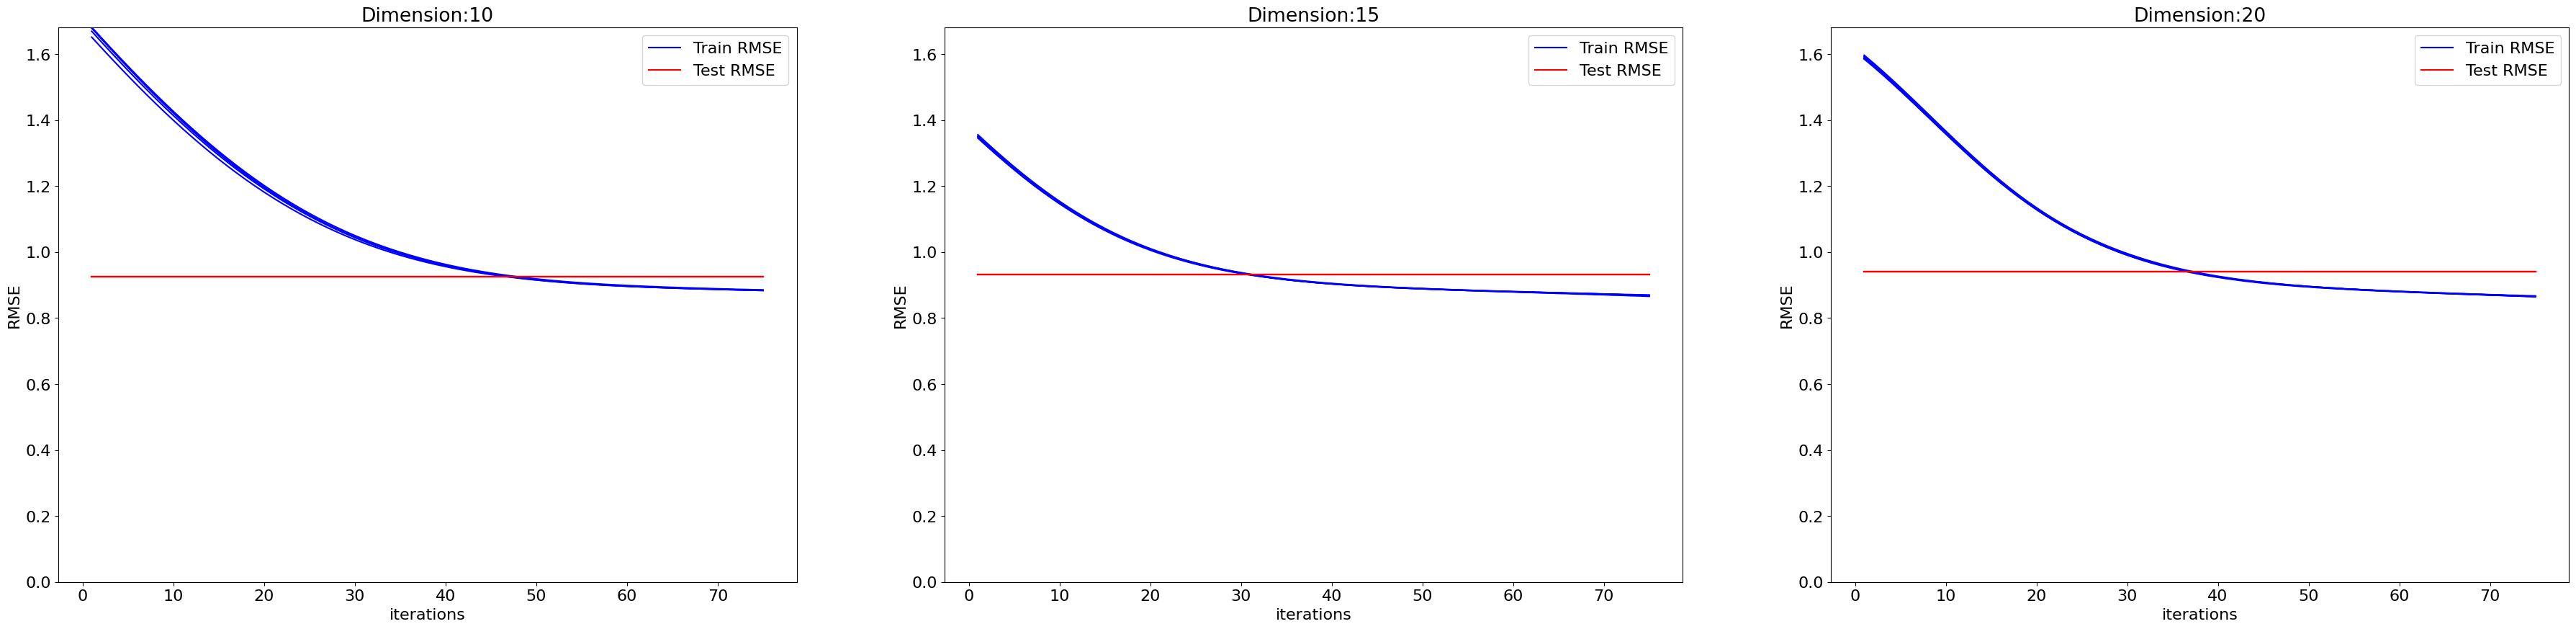

In [ ]:
plot_train=[plot1_train,plot2_train,plot3_train] #list of lists of rmses for each fold
plot_test=[plot1_test,plot2_test,plot3_test] #list of three numbers to create strainght lines

Ks = [10,15,20]
plt.rcParams['font.size'] = '16'
figure, axis = plt.subplots(1,3, figsize=(45,10))
max_rmse = max(max([max(max(train_fold), plot_test) for train_fold in plot_train]))

for i in range(3):
  for j in range(len(plot_train[i])):
      axis[i].plot(range(1, len(plot_train[i][j]) + 1), plot_train[i][j], linestyle="-", color='blue', label=f'Fold {i + 1} Train')
      y=[plot_test[i]]*len(plot_train[i][j])
      axis[i].plot(range(1, len(plot_train[i][j]) + 1), y, linestyle="-", color='red', label=f'Fold {i + 1} Test')

      axis[i].set_title('Dimension:'+ str(Ks[i]))
      axis[i].set_ylabel('RMSE')
      axis[i].set_xlabel('iterations')

      axis[i].set_ylim(0, max_rmse)

train_legend = mlines.Line2D([], [], color='blue', label='Train RMSE')
test_legend = mlines.Line2D([], [], color='red', label='Test RMSE')

# Adding legends to each subplot
axis[0].legend(handles=[train_legend, test_legend])
axis[1].legend(handles=[train_legend, test_legend])
axis[2].legend(handles=[train_legend, test_legend])

plt.show()

The lines are very similar and all the models performed rather well. The K with the best performance though, is the one with K=10 as it achieved the smallest overall RMSE and MAE.

## Output for Visualization

Perform the Matrix Factorization on all the dataset, with the best chosen K=10 and print the U and M matrices for users and movies respectively to be used for the visualization.

In [ ]:
model_v=MatrixFactorization()
model_v.fit(data_df)
U = model_v.U
M = model_v.M

Iteration: 1  train RMSE: 1.6723599110932035 train MAE: 1.4053197534357433
Iteration: 2  train RMSE: 1.6424333442076908 train MAE: 1.3768959859366652
Iteration: 3  train RMSE: 1.6128689302934212 train MAE: 1.348949091650833
Iteration: 4  train RMSE: 1.583708783100971 train MAE: 1.3215138803466133
Iteration: 5  train RMSE: 1.5549932054781697 train MAE: 1.294630209223266
Iteration: 6  train RMSE: 1.5267599777282561 train MAE: 1.268345288749682
Iteration: 7  train RMSE: 1.4990453458617221 train MAE: 1.242674486855773
Iteration: 8  train RMSE: 1.4718796548901336 train MAE: 1.2176376408447118
Iteration: 9  train RMSE: 1.4452912911184237 train MAE: 1.1932584088508473
Iteration: 10  train RMSE: 1.4193089893841595 train MAE: 1.1695410544314078
Iteration: 11  train RMSE: 1.393959577428204 train MAE: 1.1465210755674582
Iteration: 12  train RMSE: 1.3692692765816574 train MAE: 1.124199841761164
Iteration: 13  train RMSE: 1.3452615794195448 train MAE: 1.1026005948363748
Iteration: 14  train RMSE: 1

In [ ]:
np.savetxt('users_mf.csv', U, delimiter=',')
np.savetxt('movies_mf.csv', M, delimiter=',')